In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')
# Take a look at the first 250 characters in text
print(text[:250])

Length of text: 1115394 characters
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
chars2id={char:index for index, char in enumerate(vocab)}
  
id2chars=np.array(vocab)


In [ ]:
def tesx2int(text):
  return np.array([chars2id[char] for char in text])
def int2text(_int):
  return ''.join(id2chars[_int])

In [ ]:
alltext2int = tesx2int(text)
alltext2int_dataset = tf.data.Dataset.from_tensor_slices(alltext2int)

In [ ]:
for i in alltext2int_dataset.take(10):
  print(id2chars[i])

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
per_epoch = len(text)//(seq_length+1)
sequences = alltext2int_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(id2chars[seq])
for seq in sequences.take(2):
  print(int2text(seq))

['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'B' 'e' 'f'
 'o' 'r' 'e' ' ' 'w' 'e' ' ' 'p' 'r' 'o' 'c' 'e' 'e' 'd' ' ' 'a' 'n' 'y'
 ' ' 'f' 'u' 'r' 't' 'h' 'e' 'r' ',' ' ' 'h' 'e' 'a' 'r' ' ' 'm' 'e' ' '
 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'A' 'l' 'l' ':' '\n' 'S' 'p' 'e' 'a'
 'k' ',' ' ' 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'F' 'i' 'r' 's' 't' ' ' 'C'
 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'Y' 'o' 'u' ' ']
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 
are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k


In [ ]:
def split_input_next(sequence):
  input_text = sequence[:-1]#x
  next_text = sequence[1:]#y
  return input_text, next_text
split_input_next(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
train_dataset = sequences.map(split_input_next)
for input_text, next_text in train_dataset.take(2):
  print("Input :", repr(int2text(input_text.numpy())))
  print("Next:", repr(int2text(next_text.numpy())))

Input : 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Next: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
Input : 'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
Next: 're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
seed = 10000

dataset = train_dataset.shuffle(seed).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [ ]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 1 57 53 ... 51 53 59]
 [21 15 20 ...  1 51 53]
 [21  1 61 ... 43 41 58]
 ...
 [57  1 57 ... 59 56 57]
 [ 1 54 50 ... 51 53 56]
 [58 46 43 ... 47 39  8]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[57 53  1 ... 53 59 57]
 [15 20 13 ... 51 53 56]
 [ 1 61 53 ... 41 58 10]
 ...
 [ 1 57 53 ... 56 57 58]
 [54 50 39 ... 53 56 52]
 [46 43  1 ... 39  8  0]], shape=(64, 100), dtype=int64)


In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
batch_size = BATCH_SIZE

def load_model(vocab_size,embedding_dim,rnn_units,batch_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,batch_input_shape=[batch_size, None]))
  model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,recurrent_initializer=tf.keras.initializers.GlorotNormal()))
  model.add(tf.keras.layers.Dense(vocab_size))
  return model



In [ ]:
model = load_model(vocab_size = len(vocab),embedding_dim = 256,rnn_units = 1024,batch_size = BATCH_SIZE)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm_5 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_5 (Dense)              (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    print(input_example_batch)

tf.Tensor(
[[42 12  0 ...  1 46 39]
 [31 21 15 ... 30 53 51]
 [43 56 47 ... 58  1 57]
 ...
 [ 1 51 59 ... 56 43 51]
 [45 43 39 ... 53 54  1]
 [ 1 51 53 ... 39 51 43]], shape=(64, 100), dtype=int64)


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
int2text(sampled_indices)

"yRNBRyTwRC3,q'3BXJ'o aFe.o&CQOutui?gcU-XeVzVoNKE$PIoYEvSrdrTSXysoQH'RNfg\nAPdAXh$BVrUqp.VlbNoUIfamiSU"

Train

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)#非sotmax,預測結果非[0,1]from_logits設為True

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.172758


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)

In [ ]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS,callbacks=[checkpoint_callback,ReduceLROnPlateau])

Epoch 1/20
172/172 [==============================] - 14s 68ms/step - loss: 3.0410
Epoch 2/20
172/172 [==============================] - 13s 69ms/step - loss: 1.9620
Epoch 3/20
172/172 [==============================] - 13s 70ms/step - loss: 1.6701
Epoch 4/20
172/172 [==============================] - 13s 70ms/step - loss: 1.5158
Epoch 5/20
172/172 [==============================] - 13s 69ms/step - loss: 1.4276
Epoch 6/20
172/172 [==============================] - 13s 68ms/step - loss: 1.3649
Epoch 7/20
172/172 [==============================] - 13s 68ms/step - loss: 1.3156
Epoch 8/20
172/172 [==============================] - 13s 68ms/step - loss: 1.2746
Epoch 9/20
172/172 [==============================] - 13s 69ms/step - loss: 1.2309
Epoch 10/20
172/172 [==============================] - 13s 69ms/step - loss: 1.1928
Epoch 11/20
172/172 [==============================] - 13s 69ms/step - loss: 1.1570
Epoch 12/20
172/172 [==============================] - 13s 69ms/step - loss: 1.1146
E

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

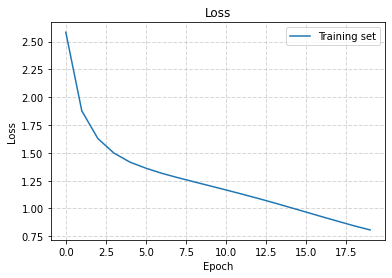

In [ ]:
render_training_history(history)

Predition

Load model from checkpoint to predit one batch(one word)

In [ ]:
print(f'checkpoint path : {tf.train.latest_checkpoint(checkpoint_dir)}')
predit_batch_size = 1
model = load_model(vocab_size = len(vocab),embedding_dim = 256,rnn_units = 1024,batch_size = predit_batch_size)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([predit_batch_size, None])) #build: 輸入shape，定義viarble的等等

checkpoint path : ./training_checkpoints/ckpt_20


In [ ]:
def generate_text(model,input_word):
  num = 1000
  temperature = 1.0 #
  input_id = tesx2int(input_word)
  input_id = tf.expand_dims(input_id, 0)
  result = []

  model.reset_states()
  for i in range(num):
    predit = model(input_id) 
    predit = predit[:,-1,:]
    predit = predit / temperature
    predit_id = tf.random.categorical(predit, num_samples=1)
    input_id = tf.expand_dims(predit_id, 0)
    predit_id = tf.squeeze(predit_id, axis=-1).numpy()
    predit_id = int2text(tf.constant(predit_id))
    result.append(predit_id)
  
  return print(input_word + ''.join(result))

In [ ]:
generate_text(model, input_word='ROMEO: ')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


ROMEO: -
But pheed of man,
For the master ribbons, of prover solum.

VIRGILIA:
Let him, madam with our souls of wark.

CAPULET:
O princK:
For which you please to be my offence?

GLOUCESTER:
Your bed-calk been have your part, aith: my lady and most
villant dowry of any of us at the dept,
And shurs his town of kings,
That I, no doubt, subtcred and when he comes,
And merriers have my daughter would great me
Your standing from his grumbling names,--dection of a funeft,
so thrive I have: there's no princely brother;
And that the one allegiance that might behold my son,
It mean not good a sight cried:
Who is't with child. Come.

AUFIDINUS:
If it.

PETRUCHIO:
Who mess' intend of your hand!
How far off, only, my body,
Prosperity! thou wouldst be put
They grant it, ere my raged it office about the streeth;
I never look to deck my talk against
Rome.

Volsce:
Coriolanus banished! thou blook'd both
To canst unwillingbushom.

Clown:
He and men with our noble enemy to thee?
Else, for thy daughter, C